In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from utils import load_data, data_augmentation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# Avoid tensorflow warnings about CPU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Model / data parameters
image_size = 200
num_classes = 50
input_shape = (image_size, image_size, 3)
validation_size = 0.1

In [4]:
optimizer = keras.optimizers.Adam(1e-5) #learning_rate=0.001 (default vaule)
epochs = 75
batch_size = 16

In [5]:
#Load dataset
X, y = load_data((image_size, image_size))
print(X.shape)

Found 3960 files belonging to 50 classes.


Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 45 extraneous bytes before marker 0xdb
Invalid SOS parameters for sequential JPEG
Corrupt JPEG data: 45 extraneous bytes before marker 0xdb


(3960, 224, 224, 3)


In [6]:
#Normalize to the range [-1, 1]
X /= 127.5
X -= 1
X, X_validation, y, y_validation = train_test_split(X, y, test_size=validation_size)

In [7]:
# Call back
#early_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [8]:
# Custom data augmentation
#X, y = data_augmentation(X, y, 2)
#print(X.shape)

# Tensorflow data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(X)

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pretrain = MobileNetV2(weights="imagenet", alpha=0.5, input_shape = input_shape, include_top = False)
#from tensorflow.keras.applications import ResNet50

#pretrain = ResNet50(weights="imagenet", input_shape = input_shape, include_top = False)

#for layer in pretrain.layers:
#    layer.trainable = False
#pretrain.layers[0].trainable = False
    
pretrain_out = pretrain.output
  
#pretrain_out = pretrain.layers[-12].output

#_input = keras.Input(shape=input_shape)

#W = layers.Conv2D(20, kernel_size=(12, 12), activation="relu", padding="same")(_input)
#W = layers.MaxPooling2D(pool_size=(2, 2))(W)
#W = layers.Conv2D(20, kernel_size=(4, 4), activation="relu", padding="same")(W)
#W = layers.MaxPooling2D(pool_size=(2, 2))(W)
#W = layers.Conv2D(120, kernel_size=(1, 1), activation="relu", padding="same")(W)
#W = layers.GlobalAveragePooling2D(pool_size=(2, 2))(W)

M = layers.MaxPooling2D()(pretrain_out)
M = layers.Flatten()(M)
M = layers.Dropout(0.5)(M)
M = layers.Dense(64)(M)
M = layers.Dropout(0.5)(M)
M = layers.Dense(num_classes, activation="softmax")(M)

model = keras.Model(inputs=pretrain.input, outputs=M)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
# Training model without tensorflow data augmentation
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "top_k_categorical_accuracy"])
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/20
201/201 [==============================] - 235s 1s/step - loss: 8.7258 - accuracy: 0.0272 - top_k_categorical_accuracy: 0.1295 - val_loss: 4.7339 - val_accuracy: 0.1092 - val_top_k_categorical_accuracy: 0.2745
Epoch 2/20
201/201 [==============================] - 206s 1s/step - loss: 4.7528 - accuracy: 0.0767 - top_k_categorical_accuracy: 0.2589 - val_loss: 4.3063 - val_accuracy: 0.1429 - val_top_k_categorical_accuracy: 0.3445
Epoch 3/20
201/201 [==============================] - 204s 1s/step - loss: 3.7361 - accuracy: 0.1249 - top_k_categorical_accuracy: 0.3653 - val_loss: 3.8924 - val_accuracy: 0.1877 - val_top_k_categorical_accuracy: 0.4146
Epoch 4/20
201/201 [==============================] - 193s 963ms/step - loss: 3.2631 - accuracy: 0.1731 - top_k_categorical_accuracy: 0.4545 - val_loss: 2.9534 - val_accuracy: 0.2885 - val_top_k_categorical_accuracy: 0.5770
Epoch 5/20
201/201 [==============================] - 193s 963ms/step - loss: 2.9135 - accuracy: 0.2349 - top_k_c

In [10]:
# Training model with tensorflow data augmentation
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "top_k_categorical_accuracy"])
history = model.fit(
         datagen.flow(X, y, batch_size=batch_size, subset='training'),
         validation_data=datagen.flow(X, y,batch_size=16, subset='validation'),
         epochs=epochs, 
         verbose=1)

Epoch 1/50
179/179 [==============================] - 169s 905ms/step - loss: 7.1158 - accuracy: 0.0486 - top_k_categorical_accuracy: 0.1731 - val_loss: 4.9490 - val_accuracy: 0.1517 - val_top_k_categorical_accuracy: 0.4143
Epoch 2/50
179/179 [==============================] - 187s 1s/step - loss: 3.2631 - accuracy: 0.2494 - top_k_categorical_accuracy: 0.5469 - val_loss: 4.1180 - val_accuracy: 0.2823 - val_top_k_categorical_accuracy: 0.5548
Epoch 3/50
179/179 [==============================] - 273s 2s/step - loss: 2.1754 - accuracy: 0.4066 - top_k_categorical_accuracy: 0.7432 - val_loss: 3.1685 - val_accuracy: 0.3722 - val_top_k_categorical_accuracy: 0.6952
Epoch 4/50
179/179 [==============================] - 167s 932ms/step - loss: 1.6411 - accuracy: 0.5413 - top_k_categorical_accuracy: 0.8363 - val_loss: 2.5331 - val_accuracy: 0.4537 - val_top_k_categorical_accuracy: 0.7697
Epoch 5/50
179/179 [==============================] - 218s 1s/step - loss: 1.3440 - accuracy: 0.6070 - top_k_c

In [11]:
# Validation of the model
scores = model.evaluate(X_validation, y_validation, verbose=1)

13/13 [==============================] - 5s 317ms/step - loss: 3.2735 - accuracy: 0.5025 - top_k_categorical_accuracy: 0.8005


In [ ]:
# Save validation set to keep it for later (Random Forest)
model_name = 'retrain_mobilenet_v4'
np.save(model_name + "/X_validation.npy", X_validation)
np.save(model_name + "/y_validation.npy", y_validation)

In [6]:
# Load the model
model_name = 'retrain_mobilenet_v3'
model = keras.models.load_model('./models/' + model_name + '.keras')

# Load validation set
X_validation = np.load(model_name + "/X_validation.npy")
y_validation = np.load(model_name + "/y_validation.npy")

In [15]:
# Predict validation set
prediction = np.argmax(model.predict(X_validation), axis=-1)
y_prediction = np.argmax(y_validation, axis=-1)

# Confusion matrix of this validation set to check accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn
cm = confusion_matrix(y_prediction, prediction)
seaborn.heatmap(cm, annot=True)

(396,)
[31 24  0 43 45 39  5 18 32 39 31  7 41 46 18 19 34 34  3 17 28  8 19 48
 36 43  3 32 38 45 40  3 22 11  0 49 49  1 32 40 28 13 43  4 49 34 21 16
 47 19 41 19  0 31 22 40  7 27 36 35 36 20 19 25 22 15 23 37 26 13 40 21
 20  4 47 21 27 14  4 48  4 40  3  7 34  0 18  7 17 31 32 46 32 37 48 38
 36 20  9 20  6 42 16 38 45 21 44 33 25 19 14 33 38 14 40 29 29 25  1 44
  5  1  3  7  2 38  5 22  2 49 35  7 41 32 14  3 42 27 10 47  0 47 20  2
  1  5  9 36 42 35 33 28  5 24 18 25 49  1 25 24 46 14 26 32 46 42 43 36
  2 20 28 12  1 18 26 17 30 19  4 11 35 34 43  0  1 19 14 27 28 42 49 29
 12 31 19 21 14 13 17  0  0 41  9  9  2 47 34 21 18 22 27 18 37 10 46  4
  7 23 49 15  0 42 16 13 16 32 14 43  9 43  3  9 44  5 16 44 45 14 13  2
 37 19 46  3  1 14 48 23  7 29 36 31 35  1 34 27 31 11 23 22 45 30 46 21
 28 31 23  9 28 20 21 14 20 26 43 39 46 48 31 44  3 22 20 21  2 28  7 12
 31 13 41 37  6 15 13 43 39 10 25  5 22 39  2 29 14 31 33 16 48 21 32 49
 38 19 44 23 25  1 35 19 45 29 37 20 39 38  

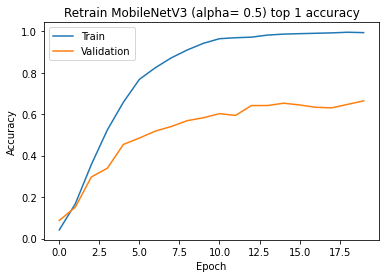

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Retrain MobileNetV4 (alpha= 0.5) top 1 accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

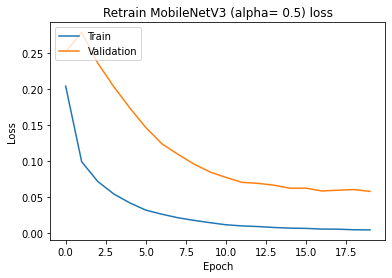

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Retrain MobileNetV4 (alpha= 0.5) loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

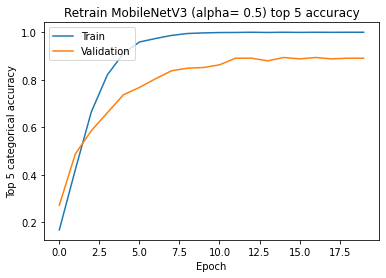

In [14]:
# Plot training & validation top 5 values
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title("Retrain MobileNetV4 (alpha= 0.5) top 5 accuracy")
plt.ylabel("Top 5 categorical accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [15]:
# Save the model
model_path = './models/' + model_name + '.keras'
model.save(model_path)